<a href="https://colab.research.google.com/github/Gowtham604/GANS_dcgan/blob/main/GANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install mxnet

     |████████████████████████████████| 46.9MB 67kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
import mxnet as mx
import numpy as np

mnist_train = mx.gluon.data.vision.datasets.MNIST(train=True)
mnist_test = mx.gluon.data.vision.datasets.MNIST(train=False)

In [3]:
# The downloaded data is of type `Dataset` which are
# Well suited to work with the new Gluon interface but less
# With the older symbol API, used in this tutorial.
# Therefore we convert them to numpy array first
X = np.zeros((70000, 28, 28))
for i, (data, label) in enumerate(mnist_train):
    X[i] = data.asnumpy()[:,:,0]
for i, (data, label) in enumerate(mnist_test):
    X[len(mnist_train)+i] = data.asnumpy()[:,:,0]

In [4]:
#Use a seed so that we get the same random permutation each time
np.random.seed(1)
p = np.random.permutation(X.shape[0])
X = X[p]

In [5]:
import cv2
X = np.asarray([cv2.resize(x, (64,64)) for x in X])

In [6]:
X = X.astype(np.float32, copy=False)/(255.0/2) - 1.0

In [7]:
X = X.reshape((70000, 1, 64, 64))
X = np.tile(X, (1, 3, 1, 1))

In [8]:
import mxnet as mx
batch_size = 64
image_iter = mx.io.NDArrayIter(X, batch_size=batch_size)

In [9]:
class RandIter(mx.io.DataIter):
    def __init__(self, batch_size, ndim):
        self.batch_size = batch_size
        self.ndim = ndim
        self.provide_data = [('rand', (batch_size, ndim, 1, 1))]
        self.provide_label = []

    def iter_next(self):
        return True

    def getdata(self):
        #Returns random numbers from a gaussian (normal) distribution
        #with mean=0 and standard deviation = 1
        return [mx.random.normal(0, 1.0, shape=(self.batch_size, self.ndim, 1, 1))]

In [10]:
Z = 100
rand_iter = RandIter(batch_size, Z)

In [11]:
no_bias = True
fix_gamma = True
epsilon = 1e-5 + 1e-12

rand = mx.sym.Variable('rand')

g1 = mx.sym.Deconvolution(rand, name='g1', kernel=(4,4), num_filter=1024, no_bias=no_bias)
gbn1 = mx.sym.BatchNorm(g1, name='gbn1', fix_gamma=fix_gamma, eps=epsilon)
gact1 = mx.sym.Activation(gbn1, name='gact1', act_type='relu')

g2 = mx.sym.Deconvolution(gact1, name='g2', kernel=(4,4), stride=(2,2), pad=(1,1), num_filter=512, no_bias=no_bias)
gbn2 = mx.sym.BatchNorm(g2, name='gbn2', fix_gamma=fix_gamma, eps=epsilon)
gact2 = mx.sym.Activation(gbn2, name='gact2', act_type='relu')

g3 = mx.sym.Deconvolution(gact2, name='g3', kernel=(4,4), stride=(2,2), pad=(1,1), num_filter=256, no_bias=no_bias)
gbn3 = mx.sym.BatchNorm(g3, name='gbn3', fix_gamma=fix_gamma, eps=epsilon)
gact3 = mx.sym.Activation(gbn3, name='gact3', act_type='relu')

g4 = mx.sym.Deconvolution(gact3, name='g4', kernel=(4,4), stride=(2,2), pad=(1,1), num_filter=128, no_bias=no_bias)
gbn4 = mx.sym.BatchNorm(g4, name='gbn4', fix_gamma=fix_gamma, eps=epsilon)
gact4 = mx.sym.Activation(gbn4, name='gact4', act_type='relu')

g5 = mx.sym.Deconvolution(gact4, name='g5', kernel=(4,4), stride=(2,2), pad=(1,1), num_filter=3, no_bias=no_bias)
generatorSymbol = mx.sym.Activation(g5, name='gact5', act_type='tanh')

In [12]:
data = mx.sym.Variable('data')

d1 = mx.sym.Convolution(data, name='d1', kernel=(4,4), stride=(2,2), pad=(1,1), num_filter=128, no_bias=no_bias)
dact1 = mx.sym.LeakyReLU(d1, name='dact1', act_type='leaky', slope=0.2)

d2 = mx.sym.Convolution(dact1, name='d2', kernel=(4,4), stride=(2,2), pad=(1,1), num_filter=256, no_bias=no_bias)
dbn2 = mx.sym.BatchNorm(d2, name='dbn2', fix_gamma=fix_gamma, eps=epsilon)
dact2 = mx.sym.LeakyReLU(dbn2, name='dact2', act_type='leaky', slope=0.2)

d3 = mx.sym.Convolution(dact2, name='d3', kernel=(4,4), stride=(2,2), pad=(1,1), num_filter=512, no_bias=no_bias)
dbn3 = mx.sym.BatchNorm(d3, name='dbn3', fix_gamma=fix_gamma, eps=epsilon)
dact3 = mx.sym.LeakyReLU(dbn3, name='dact3', act_type='leaky', slope=0.2)

d4 = mx.sym.Convolution(dact3, name='d4', kernel=(4,4), stride=(2,2), pad=(1,1), num_filter=1024, no_bias=no_bias)
dbn4 = mx.sym.BatchNorm(d4, name='dbn4', fix_gamma=fix_gamma, eps=epsilon)
dact4 = mx.sym.LeakyReLU(dbn4, name='dact4', act_type='leaky', slope=0.2)

d5 = mx.sym.Convolution(dact4, name='d5', kernel=(4,4), num_filter=1, no_bias=no_bias)
d5 = mx.sym.Flatten(d5)

label = mx.sym.Variable('label')
discriminatorSymbol = mx.sym.LogisticRegressionOutput(data=d5, label=label, name='dloss')

In [13]:
#Hyper-parameters
sigma = 0.02
lr = 0.0002
beta1 = 0.5
# Define the compute context, use GPU if available
ctx = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()

#=============Generator Module=============
generator = mx.mod.Module(symbol=generatorSymbol, data_names=('rand',), label_names=None, context=ctx)
generator.bind(data_shapes=rand_iter.provide_data)
generator.init_params(initializer=mx.init.Normal(sigma))
generator.init_optimizer(
    optimizer='adam',
    optimizer_params={
        'learning_rate': lr,
        'beta1': beta1,
    })
mods = [generator]

# =============Discriminator Module=============
discriminator = mx.mod.Module(symbol=discriminatorSymbol, data_names=('data',), label_names=('label',), context=ctx)
discriminator.bind(data_shapes=image_iter.provide_data,
          label_shapes=[('label', (batch_size,))],
          inputs_need_grad=True)
discriminator.init_params(initializer=mx.init.Normal(sigma))
discriminator.init_optimizer(
    optimizer='adam',
    optimizer_params={
        'learning_rate': lr,
        'beta1': beta1,
    })
mods.append(discriminator)

In [14]:
from matplotlib import pyplot as plt

#Takes the images in the batch and arranges them in an array so that they can be
#Plotted using matplotlib
def fill_buf(buf, num_images, img, shape):
    width = buf.shape[0]/shape[1]
    height = buf.shape[1]/shape[0]
    img_width = int(num_images%width)*shape[0]
    img_hight = int(num_images/height)*shape[1]
    buf[img_hight:img_hight+shape[1], img_width:img_width+shape[0], :] = img

#Plots two images side by side using matplotlib
def visualize(fake, real):
    #64x3x64x64 to 64x64x64x3
    fake = fake.transpose((0, 2, 3, 1))
    #Pixel values from 0-255
    fake = np.clip((fake+1.0)*(255.0/2.0), 0, 255).astype(np.uint8)
    #Repeat for real image
    real = real.transpose((0, 2, 3, 1))
    real = np.clip((real+1.0)*(255.0/2.0), 0, 255).astype(np.uint8)

    #Create buffer array that will hold all the images in the batch
    #Fill the buffer so to arrange all images in the batch onto the buffer array
    n = np.ceil(np.sqrt(fake.shape[0]))
    fbuff = np.zeros((int(n*fake.shape[1]), int(n*fake.shape[2]), int(fake.shape[3])), dtype=np.uint8)
    for i, img in enumerate(fake):
        fill_buf(fbuff, i, img, fake.shape[1:3])
    rbuff = np.zeros((int(n*real.shape[1]), int(n*real.shape[2]), int(real.shape[3])), dtype=np.uint8)
    for i, img in enumerate(real):
        fill_buf(rbuff, i, img, real.shape[1:3])

    #Create a matplotlib figure with two subplots: one for the real and the other for the fake
    #fill each plot with the buffer array, which creates the image
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(fbuff)
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(rbuff)
    plt.show()

Training...
epoch: 0 iter: 50
   From generator:        From MNIST:


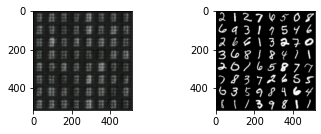

epoch: 0 iter: 100
   From generator:        From MNIST:


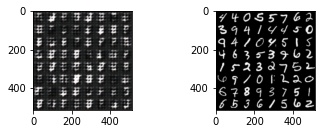

epoch: 0 iter: 150
   From generator:        From MNIST:


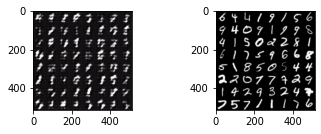

epoch: 0 iter: 200
   From generator:        From MNIST:


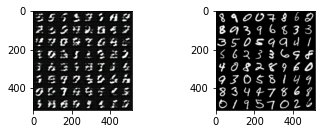

epoch: 0 iter: 250
   From generator:        From MNIST:


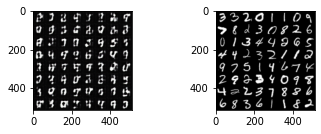

epoch: 0 iter: 300
   From generator:        From MNIST:


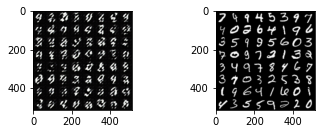

epoch: 0 iter: 350
   From generator:        From MNIST:


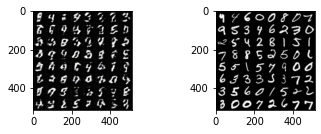

epoch: 0 iter: 400
   From generator:        From MNIST:


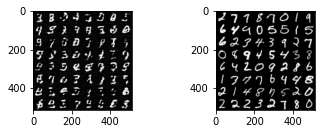

epoch: 0 iter: 450
   From generator:        From MNIST:


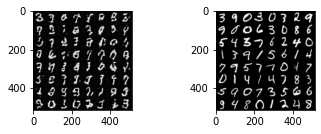

epoch: 0 iter: 500
   From generator:        From MNIST:


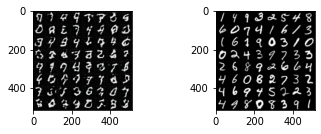

epoch: 0 iter: 550
   From generator:        From MNIST:


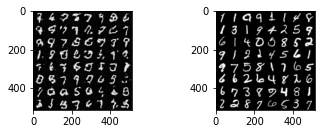

epoch: 0 iter: 600
   From generator:        From MNIST:


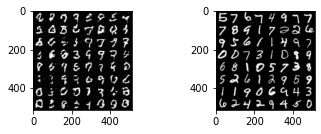

epoch: 0 iter: 650
   From generator:        From MNIST:


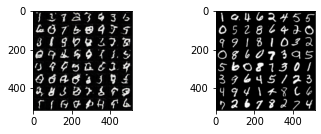

epoch: 0 iter: 700
   From generator:        From MNIST:


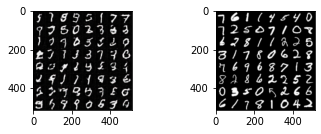

epoch: 0 iter: 750
   From generator:        From MNIST:


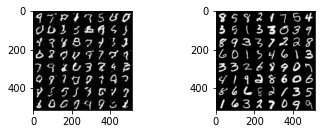

epoch: 0 iter: 800
   From generator:        From MNIST:


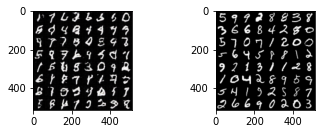

epoch: 0 iter: 850
   From generator:        From MNIST:


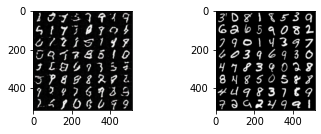

epoch: 0 iter: 900
   From generator:        From MNIST:


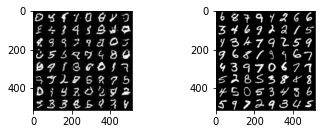

epoch: 0 iter: 950
   From generator:        From MNIST:


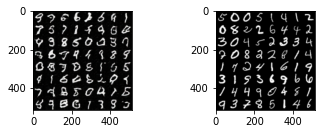

epoch: 0 iter: 1000
   From generator:        From MNIST:


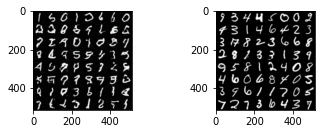

epoch: 0 iter: 1050
   From generator:        From MNIST:


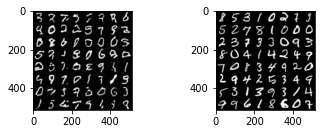

epoch: 1 iter: 50
   From generator:        From MNIST:


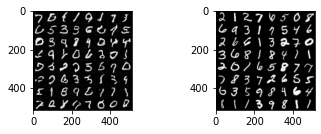

epoch: 1 iter: 100
   From generator:        From MNIST:


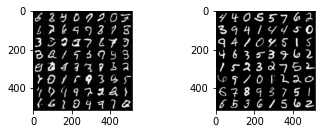

epoch: 1 iter: 150
   From generator:        From MNIST:


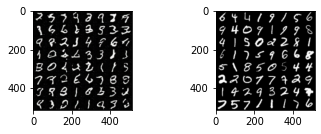

epoch: 1 iter: 200
   From generator:        From MNIST:


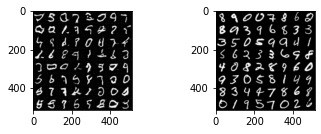

epoch: 1 iter: 250
   From generator:        From MNIST:


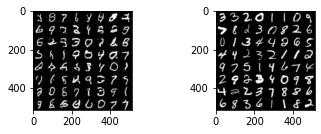

epoch: 1 iter: 300
   From generator:        From MNIST:


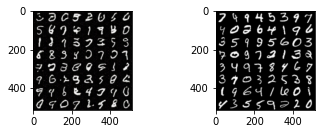

epoch: 1 iter: 350
   From generator:        From MNIST:


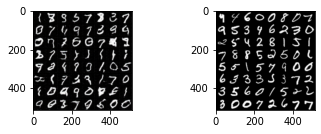

epoch: 1 iter: 400
   From generator:        From MNIST:


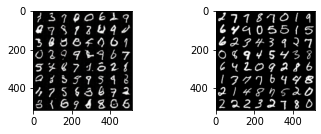

epoch: 1 iter: 450
   From generator:        From MNIST:


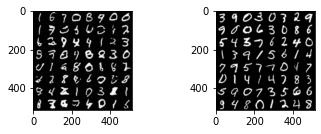

epoch: 1 iter: 500
   From generator:        From MNIST:


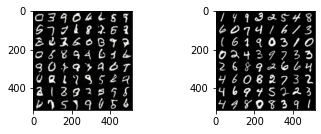

epoch: 1 iter: 550
   From generator:        From MNIST:


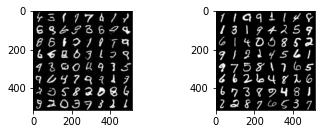

epoch: 1 iter: 600
   From generator:        From MNIST:


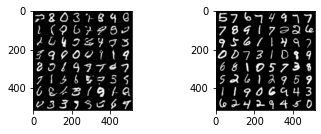

epoch: 1 iter: 650
   From generator:        From MNIST:


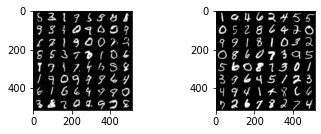

epoch: 1 iter: 700
   From generator:        From MNIST:


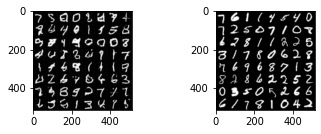

epoch: 1 iter: 750
   From generator:        From MNIST:


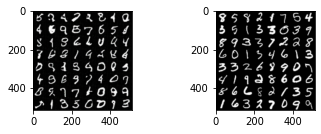

epoch: 1 iter: 800
   From generator:        From MNIST:


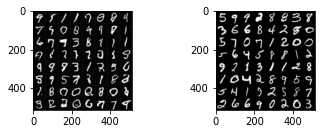

epoch: 1 iter: 850
   From generator:        From MNIST:


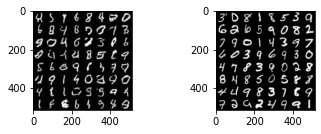

epoch: 1 iter: 900
   From generator:        From MNIST:


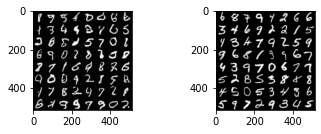

epoch: 1 iter: 950
   From generator:        From MNIST:


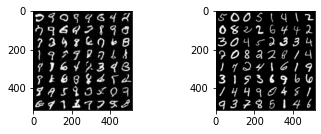

epoch: 1 iter: 1000
   From generator:        From MNIST:


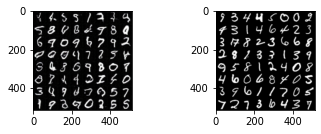

epoch: 1 iter: 1050
   From generator:        From MNIST:


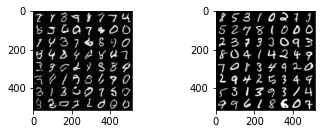

epoch: 2 iter: 50
   From generator:        From MNIST:


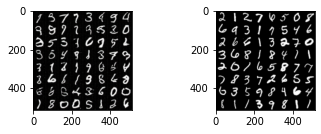

epoch: 2 iter: 100
   From generator:        From MNIST:


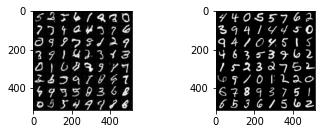

epoch: 2 iter: 150
   From generator:        From MNIST:


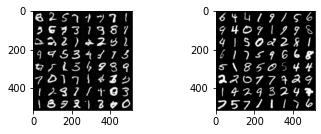

epoch: 2 iter: 200
   From generator:        From MNIST:


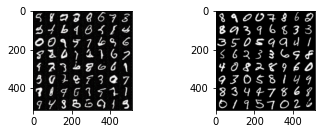

epoch: 2 iter: 250
   From generator:        From MNIST:


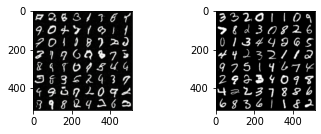

epoch: 2 iter: 300
   From generator:        From MNIST:


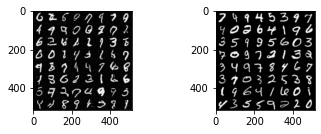

epoch: 2 iter: 350
   From generator:        From MNIST:


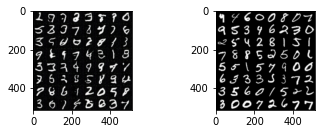

epoch: 2 iter: 400
   From generator:        From MNIST:


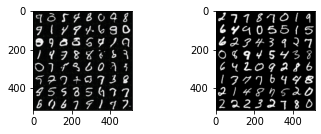

epoch: 2 iter: 450
   From generator:        From MNIST:


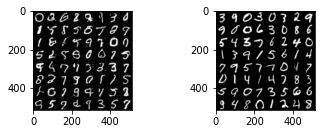

epoch: 2 iter: 500
   From generator:        From MNIST:


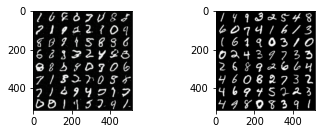

epoch: 2 iter: 550
   From generator:        From MNIST:


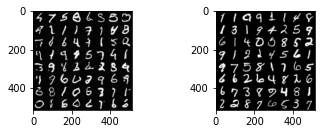

epoch: 2 iter: 600
   From generator:        From MNIST:


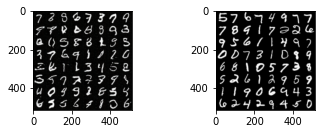

epoch: 2 iter: 650
   From generator:        From MNIST:


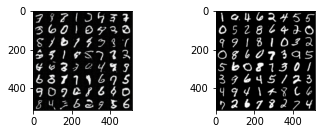

epoch: 2 iter: 700
   From generator:        From MNIST:


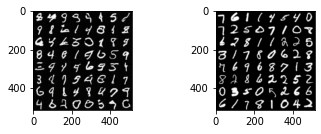

epoch: 2 iter: 750
   From generator:        From MNIST:


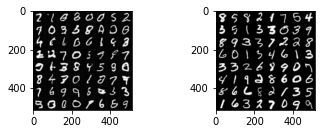

epoch: 2 iter: 800
   From generator:        From MNIST:


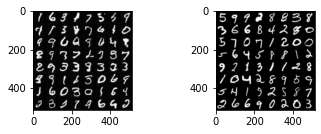

epoch: 2 iter: 850
   From generator:        From MNIST:


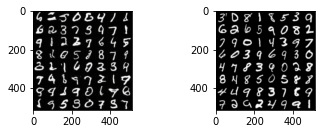

epoch: 2 iter: 900
   From generator:        From MNIST:


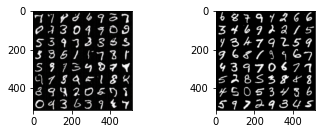

epoch: 2 iter: 950
   From generator:        From MNIST:


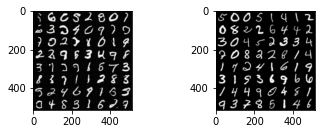

epoch: 2 iter: 1000
   From generator:        From MNIST:


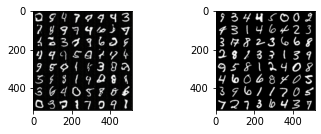

epoch: 2 iter: 1050
   From generator:        From MNIST:


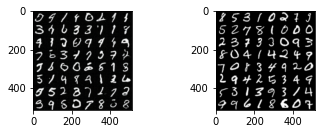

epoch: 3 iter: 50
   From generator:        From MNIST:


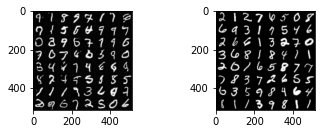

epoch: 3 iter: 100
   From generator:        From MNIST:


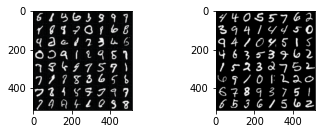

epoch: 3 iter: 150
   From generator:        From MNIST:


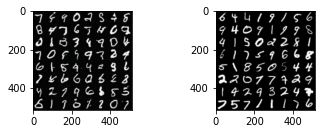

epoch: 3 iter: 200
   From generator:        From MNIST:


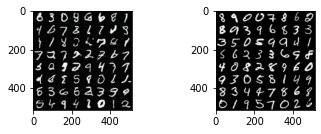

epoch: 3 iter: 250
   From generator:        From MNIST:


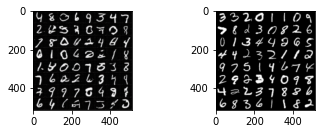

epoch: 3 iter: 300
   From generator:        From MNIST:


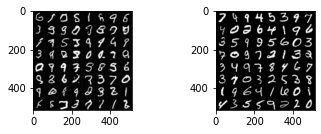

epoch: 3 iter: 350
   From generator:        From MNIST:


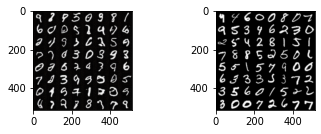

epoch: 3 iter: 400
   From generator:        From MNIST:


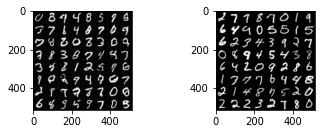

epoch: 3 iter: 450
   From generator:        From MNIST:


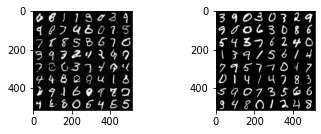

epoch: 3 iter: 500
   From generator:        From MNIST:


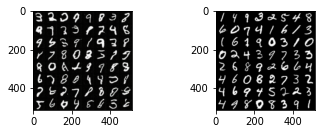

epoch: 3 iter: 550
   From generator:        From MNIST:


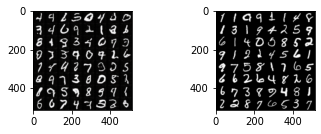

epoch: 3 iter: 600
   From generator:        From MNIST:


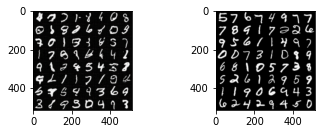

epoch: 3 iter: 650
   From generator:        From MNIST:


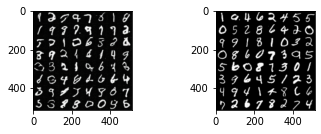

epoch: 3 iter: 700
   From generator:        From MNIST:


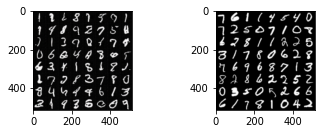

epoch: 3 iter: 750
   From generator:        From MNIST:


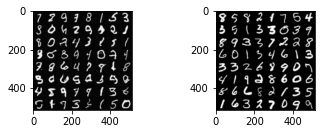

epoch: 3 iter: 800
   From generator:        From MNIST:


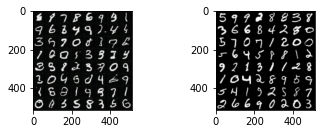

epoch: 3 iter: 850
   From generator:        From MNIST:


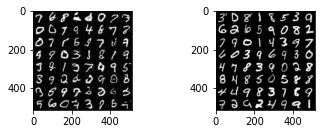

epoch: 3 iter: 900
   From generator:        From MNIST:


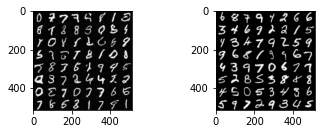

epoch: 3 iter: 950
   From generator:        From MNIST:


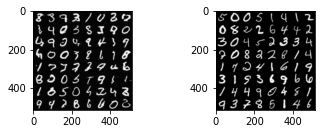

epoch: 3 iter: 1000
   From generator:        From MNIST:


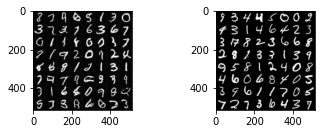

epoch: 3 iter: 1050
   From generator:        From MNIST:


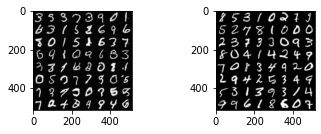

In [15]:
# =============train===============
print('Training...')
for epoch in range(4):
    image_iter.reset()
    for i, batch in enumerate(image_iter):
        #Get a batch of random numbers to generate an image from the generator
        rbatch = rand_iter.next()
        #Forward pass on training batch
        generator.forward(rbatch, is_train=True)
        #Output of training batch is the 64x64x3 image
        outG = generator.get_outputs()

        #Pass the generated (fake) image through the discriminator, and save the gradient
        #Label (for logistic regression) is an array of 0's since this image is fake
        label = mx.nd.zeros((batch_size,), ctx=ctx)
        #Forward pass on the output of the discriminator network
        discriminator.forward(mx.io.DataBatch(outG, [label]), is_train=True)
        #Do the backward pass and save the gradient
        discriminator.backward()
        gradD = [[grad.copyto(grad.context) for grad in grads] for grads in discriminator._exec_group.grad_arrays]

        #Pass a batch of real images from MNIST through the discriminator
        #Set the label to be an array of 1's because these are the real images
        label[:] = 1
        batch.label = [label]
        #Forward pass on a batch of MNIST images
        discriminator.forward(batch, is_train=True)
        #Do the backward pass and add the saved gradient from the fake images to the gradient
        #generated by this backwards pass on the real images
        discriminator.backward()
        for gradsr, gradsf in zip(discriminator._exec_group.grad_arrays, gradD):
            for gradr, gradf in zip(gradsr, gradsf):
                gradr += gradf
        #Update gradient on the discriminator
        discriminator.update()

        #Now that we've updated the discriminator, let's update the generator
        #First do a forward pass and backwards pass on the newly updated discriminator
        #With the current batch
        discriminator.forward(mx.io.DataBatch(outG, [label]), is_train=True)
        discriminator.backward()
        #Get the input gradient from the backwards pass on the discriminator,
        #and use it to do the backwards pass on the generator
        diffD = discriminator.get_input_grads()
        generator.backward(diffD)
        #Update the gradients on the generator
        generator.update()

        #Increment to the next batch, printing every 50 batches
        i += 1
        if i % 50 == 0:
            print('epoch:', epoch, 'iter:', i)
            print
            print("   From generator:        From MNIST:")

            visualize(outG[0].asnumpy(), batch.data[0].asnumpy())

# New Section